# GTSF phase: biomass prediction

In this notebook, we are forecasting the weights by finding the closest blender model

### Look at the volumes created with blender

Load blender data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2

import glob
import os
import boto3
import tempfile
from sqlalchemy import create_engine, MetaData, Table, select, and_, func
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.automap import automap_base
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import tqdm
import pickle
from itertools import combinations

from PIL import Image, ImageDraw
from multiprocessing import Pool, Manager
import copy
import uuid





<h1> Get world keypoint coordinates from GTSF data </h1>

In [2]:
aws_credentials = json.load(open(os.environ["AWS_CREDENTIALS"]))
s3_client = boto3.client('s3', aws_access_key_id=aws_credentials["aws_access_key_id"],
                         aws_secret_access_key=aws_credentials["aws_secret_access_key"],
                         region_name="eu-west-1")


sql_credentials = json.load(open(os.environ["SQL_CREDENTIALS"]))
sql_engine = create_engine("postgresql://{}:{}@{}:{}/{}".format(sql_credentials["user"], sql_credentials["password"],
                           sql_credentials["host"], sql_credentials["port"],
                           sql_credentials["database"]))

Session = sessionmaker(bind=sql_engine)
session = Session()

Base = automap_base()
Base.prepare(sql_engine, reflect=True)
Enclosure = Base.classes.enclosures
Calibration = Base.classes.calibrations
GtsfDataCollection = Base.classes.gtsf_data_collections
StereoFramePair = Base.classes.stereo_frame_pairs


/usr/local/lib/python3.5/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


<h1> Utility functions for world keypoint normalization </h1>

In [3]:
def generate_rotation_matrix(u_base, v):
    u = v / np.linalg.norm(v)
    n = np.cross(u_base, u)
    n = n / np.linalg.norm(n)
    theta = -np.arccos(np.dot(u, u_base))

    R = np.array([[
        np.cos(theta) + n[0]**2*(1-np.cos(theta)), 
        n[0]*n[1]*(1-np.cos(theta)) - n[2]*np.sin(theta),
        n[0]*n[2]*(1-np.cos(theta)) + n[1]*np.sin(theta)
    ], [
        n[1]*n[0]*(1-np.cos(theta)) + n[2]*np.sin(theta),
        np.cos(theta) + n[1]**2*(1-np.cos(theta)),
        n[1]*n[2]*(1-np.cos(theta)) - n[0]*np.sin(theta),
    ], [
        n[2]*n[0]*(1-np.cos(theta)) - n[1]*np.sin(theta),
        n[2]*n[1]*(1-np.cos(theta)) + n[0]*np.sin(theta),
        np.cos(theta) + n[2]**2*(1-np.cos(theta))
    ]])
    
    return R

In [4]:
def euclidean_distance(p1, p2):
    if type(p1) == list:
        p1 = np.array(p1)
    if type(p2) == list:
        p2 = np.array(p2)
    return np.linalg.norm(p1 - p2)


def normalize_world_keypoints(wkps):
    body_parts = wkps.keys()
    
    # translate keypoints such that tail notch is at origin
    translated_wkps = {bp: wkps[bp] - wkps['TAIL_NOTCH'] for bp in body_parts}
    
    # perform first rotation
    u_base=np.array([1, 0, 0])
    v = translated_wkps['UPPER_LIP']
    R = generate_rotation_matrix(u_base, v)
    norm_wkps_intermediate = {bp: np.dot(R, translated_wkps[bp]) for bp in body_parts}
    
    # perform second rotation
    u_base = np.array([0, 0, 1])
    v = norm_wkps_intermediate['DORSAL_FIN'] - np.array([norm_wkps_intermediate['DORSAL_FIN'][0], 0, 0])
    R = generate_rotation_matrix(u_base, v)
    norm_wkps = {bp: np.dot(R, norm_wkps_intermediate[bp]) for bp in body_parts}
    
    # perform reflecton if necessary
    if norm_wkps['PECTORAL_FIN'][1] > 0:
        norm_wkps = {bp: np.array([
            norm_wkps[bp][0],
            -norm_wkps[bp][1],
            norm_wkps[bp][2]
        ]) for bp in body_parts}
    
    return norm_wkps
    



<h1> Utility Method: World Keypoint Calculation </h1>

In [5]:
# DEFINE OPTICAL PROPERTIES

# all distance are in meters
FOCAL_LENGTH = 0.00843663
BASELINE = 0.128096
PIXEL_SIZE_M = 3.45 * 1e-6
FOCAL_LENGTH_PIXEL = FOCAL_LENGTH / PIXEL_SIZE_M
IMAGE_SENSOR_WIDTH = 0.01412
IMAGE_SENSOR_HEIGHT = 0.01035
PIXEL_COUNT_WIDTH = 4096
PIXEL_COUNT_HEIGHT = 3000

def convert_to_world_point(x, y, d):
    """ from pixel coordinates to world coordinates """
    
    image_center_x = PIXEL_COUNT_WIDTH / 2.0  
    image_center_y = PIXEL_COUNT_HEIGHT / 2.0
    px_x = x - image_center_x
    px_z = image_center_y - y

    sensor_x = px_x * (IMAGE_SENSOR_WIDTH / PIXEL_COUNT_WIDTH)
    sensor_z = px_z * (IMAGE_SENSOR_HEIGHT / PIXEL_COUNT_HEIGHT)

    # d = depth_map[y, x]
    world_y = d
    world_x = (world_y * sensor_x) / FOCAL_LENGTH
    world_z = (world_y * sensor_z) / FOCAL_LENGTH
    return np.array([world_x, world_y, world_z])

def depth_from_disp(disp):
    """ calculate the depth of the point based on the disparity value """
    depth = FOCAL_LENGTH_PIXEL*BASELINE / np.array(disp)
    return depth

def disp_from_depth(depth):
    disp = FOCAL_LENGTH_PIXEL * BASELINE / depth
    return disp


<h1> Generate accuracy metrics on GTSF data </h1>

In [6]:
body_parts = [
    'TAIL_NOTCH',
    'ADIPOSE_FIN',
    'ANAL_FIN',
    'PECTORAL_FIN',
    'PELVIC_FIN',
    'DORSAL_FIN',
    'UPPER_LIP',
    'EYE'
]

In [7]:
def generate_lateral_keypoints(left_image, right_image, left_keypoints, right_keypoints, world_keypoints, 
                               bp_1='UPPER_LIP', bp_2='TAIL_NOTCH', left_window_size=100, 
                               min_breadth=0.04, max_breadth=0.2):
    left_extrap_kp = (0.5 * left_keypoints[bp_1] + 0.5 * left_keypoints[bp_2]).astype('int64')
    bp_1_depth = world_keypoints[bp_1][1]
    bp_2_depth = world_keypoints[bp_2][1]

    # need to determine lower and upper bounds here in a data driven fashion from GTSF data
    # hardcoded values used here
    extrap_kp_max_depth = (bp_1_depth + bp_2_depth) / 2.0 - min_breadth / 2.0
    extrap_kp_min_depth = (bp_1_depth + bp_2_depth) / 2.0 - max_breadth / 2.0

    # Compute the feature descriptor for the extrapolated keypoint in the left image
    extrap_kp_min_disp = disp_from_depth(extrap_kp_max_depth)
    extrap_kp_max_disp = disp_from_depth(extrap_kp_min_depth)
    
    left_box = left_image[left_extrap_kp[1]-left_window_size//2:left_extrap_kp[1]+left_window_size//2, 
                          left_extrap_kp[0]-left_window_size//2:left_extrap_kp[0]+left_window_size//2]
    right_box = right_image[left_extrap_kp[1]-left_window_size//2:left_extrap_kp[1]+left_window_size//2,
                            left_extrap_kp[0]-int(extrap_kp_max_disp)-left_window_size//2:left_extrap_kp[0]-int(extrap_kp_min_disp)+left_window_size//2]

    
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(left_box,None)
    kp2, des2 = orb.detectAndCompute(right_box,None)
    
    # get top five matches
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1,des2)
    matches = sorted(matches, key = lambda x:x.distance)[:5]
    
    # get world coordinates of lateral keypoints
    lateral_wkps = []
    for match in matches[:5]:
        
        lateral_left_coordinates = np.array(kp1[match.queryIdx].pt).astype(int)
        lateral_left_coordinates[0] += left_extrap_kp[0]-left_window_size//2
        lateral_left_coordinates[1] += left_extrap_kp[1]-left_window_size//2
        
        lateral_right_coordinates = np.array(kp2[match.trainIdx].pt).astype(int)
        lateral_right_coordinates[0] += left_extrap_kp[0]-int(extrap_kp_max_disp)-left_window_size//2
        lateral_right_coordinates[1] += left_extrap_kp[1]-left_window_size//2
        
        disp = abs(lateral_left_coordinates[0] - lateral_right_coordinates[0])
        depth = depth_from_disp(disp)
        lateral_wkp = convert_to_world_point(lateral_left_coordinates[0], lateral_left_coordinates[1], depth)
        lateral_wkps.append(lateral_wkp)
        
    return np.array(lateral_wkps)


def process_stereo_frame_pair(sfp, world_keypoints_dict):
    if sfp['gtsf_fish_identifier'] == '190321010002':
        return
    ground_truth_metadata = json.loads(sfp['ground_truth_metadata'])
    if ground_truth_metadata['data'].get('species') != 'salmon':
        return
        
    # download left and right images
    random_hash = uuid.uuid4().hex
    left_image_f = 'left_image_{}.jpg'.format(random_hash)
    right_image_f = 'right_image_{}.jpg'.format(random_hash)

    left_image_s3_key, right_image_s3_key, s3_bucket = sfp['left_image_s3_key'], sfp['right_image_s3_key'], sfp['image_s3_bucket']
    s3_client.download_file(s3_bucket, left_image_s3_key, left_image_f)
    s3_client.download_file(s3_bucket, right_image_s3_key, right_image_f)
    
    left_image = cv2.imread(left_image_f)
    right_image = cv2.imread(right_image_f)
    
    # get left, right, and world keypoints
    left_keypoints = json.loads(sfp['left_image_keypoint_coordinates'])
    right_keypoints = json.loads(sfp['right_image_keypoint_coordinates'])
    world_keypoints = json.loads(sfp['world_keypoint_coordinates'])
    
    # convert coordinates from lists to numpy arrays
    left_keypoints = {k: np.array(v) for k, v in left_keypoints.items()}
    right_keypoints = {k: np.array(v) for k, v in right_keypoints.items()}
    world_keypoints = {k: np.array(v) for k, v in world_keypoints.items()}
     
    lateral_wkps = generate_lateral_keypoints(left_image, right_image, left_keypoints, right_keypoints, world_keypoints)
    world_keypoints['BODY'] = lateral_wkps
    world_keypoints_dict[sfp['id']] = world_keypoints
    print(len(world_keypoints_dict))
    
    os.remove(left_image_f)
    os.remove(right_image_f)
    



In [9]:
manager = Manager()
world_keypoints_dict = manager.dict()

session.rollback()
sfps_all = session.query(StereoFramePair).all()
args = []
for row in sfps_all:
    row_copy = copy.copy(row)
    sfp = row_copy.__dict__
    del sfp['_sa_instance_state']
    args.append((sfp, world_keypoints_dict))

pool = Pool(processes=20)
pool.starmap(process_stereo_frame_pair, args)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [8]:
pickle.dump(world_keypoints_dict, open('world_keypoints_dict.pkl', 'wb'))

NameError: name 'world_keypoints_dict' is not defined

In [9]:
world_keypoints_dict = pickle.load(open('world_keypoints_dict.pkl', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory

In [54]:
len(world_keypoints_dict)

649

In [55]:
print(type(world_keypoints_dict[192]))

<class 'dict'>


In [56]:
df = pd.DataFrame()

for idx, row in enumerate(sfps_all):
    if idx % 10 == 0:
        print(idx)
        
    # get fish_id and ground truth metadata
    if row.gtsf_fish_identifier == '190321010002':
        continue
    gtsf_data_collection_id = row.gtsf_data_collection_id
    gtsf_data_collection = session.query(GtsfDataCollection).get(gtsf_data_collection_id)
    ground_truth_metadata = json.loads(gtsf_data_collection.ground_truth_metadata)
    if ground_truth_metadata['data'].get('species') != 'salmon':
        continue
    
    world_keypoints = world_keypoints_dict[row.id]
    body_wkp = world_keypoints['BODY'].mean(axis=0)
    wkps = copy.copy(world_keypoints)
    wkps['BODY'] = body_wkp
    body_parts = list(wkps.keys())
    
    row = {'0': idx}
    for i in range(len(body_parts)-1):
        for j in range(i+1, len(body_parts)):
            d = euclidean_distance(wkps[body_parts[i]], wkps[body_parts[j]])
            row['{0}-{1}'.format(i, j)] = d
    
    
    weight = ground_truth_metadata['data']['weight']
    length = ground_truth_metadata['data']['length']
    row['weight'] = weight
    row['length'] = length
    row['kfactor'] = 1e5 * weight / length**3
    df = df.append(row, ignore_index=True)
            
    
                                                       



0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660


In [57]:
df_cache = df.copy()
df = df.dropna()

In [58]:
def generate_train_mask(df, train_frac, randomize=True):
    x = np.zeros((df.shape[0]), dtype=bool)
    x[:int(train_frac * df.shape[0])] = True
    np.random.shuffle(x)
    mask = pd.Series(x)
    return x
    
    

In [59]:
mask = generate_train_mask(df, train_frac=0.8)


columns = ['{0}-{1}'.format(x, y) for x, y in list(combinations(list(range(8)), 2))]
X_train = df.loc[mask, columns].values
y_train = df.loc[mask, 'weight'].values
X_test = df.loc[~mask, columns].values
y_test = df.loc[~mask, 'weight'].values

reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)
y_pred = reg.predict(df[columns].values)
df['prediction'] = y_pred
df['error'] = df.prediction - df.weight
df['error_pct'] = df.error / df.weight
df['abs_error_pct'] = df.error_pct.abs()



Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/usr/local/lib/python3.5/dist-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/lib/python3.5/dist-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: SSL SYSCALL error: EOF detected



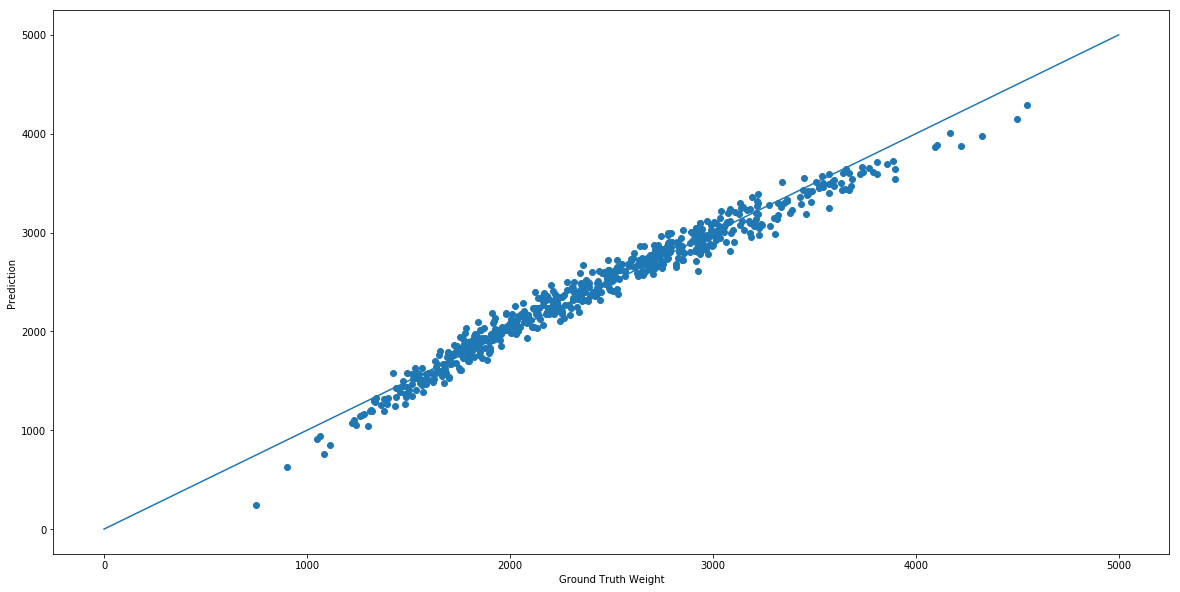

In [60]:
%matplotlib inline
plt.figure(figsize=(20, 10))
plt.scatter(df.weight, df.prediction)
plt.xlabel('Ground Truth Weight')
plt.ylabel('Prediction')
plt.plot(range(5000), range(5000))


In [44]:
N = 100

# perform N-fold cross validation
abs_err_pcts = []
for i in range(N):
    if i % 10 == 0:
        print(i)
    mask = generate_train_mask(df, train_frac=0.615)

    columns = ['{0}-{1}'.format(x, y) for x, y in list(combinations(list(range(8)), 2))]
    X_train = df.loc[mask, columns].values
    y_train = df.loc[mask, 'weight'].values
    X_test = df.loc[~mask, columns].values
    y_test = df.loc[~mask, 'weight'].values

    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(df[columns].values)
    df['prediction'] = y_pred
    df['error'] = df.prediction - df.weight
    df['error_pct'] = df.error / df.weight
    df['abs_error_pct'] = df.error_pct.abs()
    
    avg_biomass_err = df.loc[~mask, 'prediction'].mean() - df.loc[~mask, 'weight'].mean()
    abs_err_pct = abs(avg_biomass_err) / df.loc[~mask, 'weight'].mean()
    abs_err_pcts.append(abs_err_pct)
    
    



0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

10


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

20


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

30


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

40


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

50


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

60


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

70


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

80


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

90


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

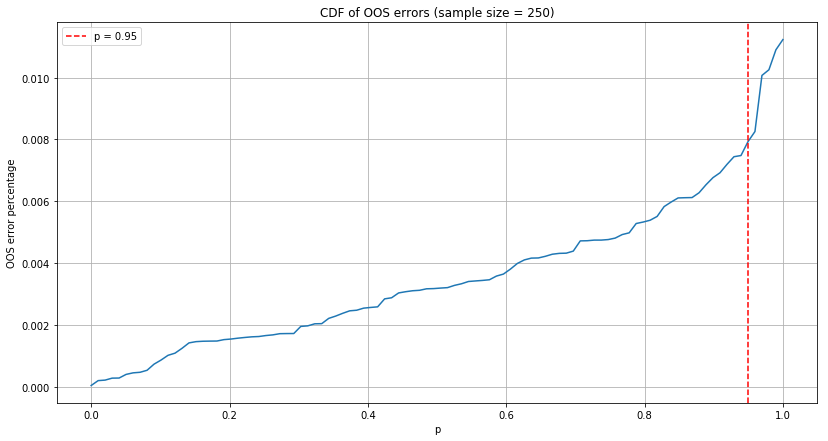

In [45]:
data_sorted = sorted(list(abs_err_pcts))
p = 1.0 * np.arange(len(data_sorted)) / (len(data_sorted) - 1)
fig = plt.figure(figsize=(30, 7))
ax1 = fig.add_subplot(121)
ax1.plot(p, data_sorted)
ax1.set_xlabel('p')
ax1.set_ylabel('OOS error percentage')
plt.axvline(x=0.95, linestyle='--', color='red', label='p = 0.95')
plt.title('CDF of OOS errors (sample size = 250)')
plt.legend()
plt.grid()



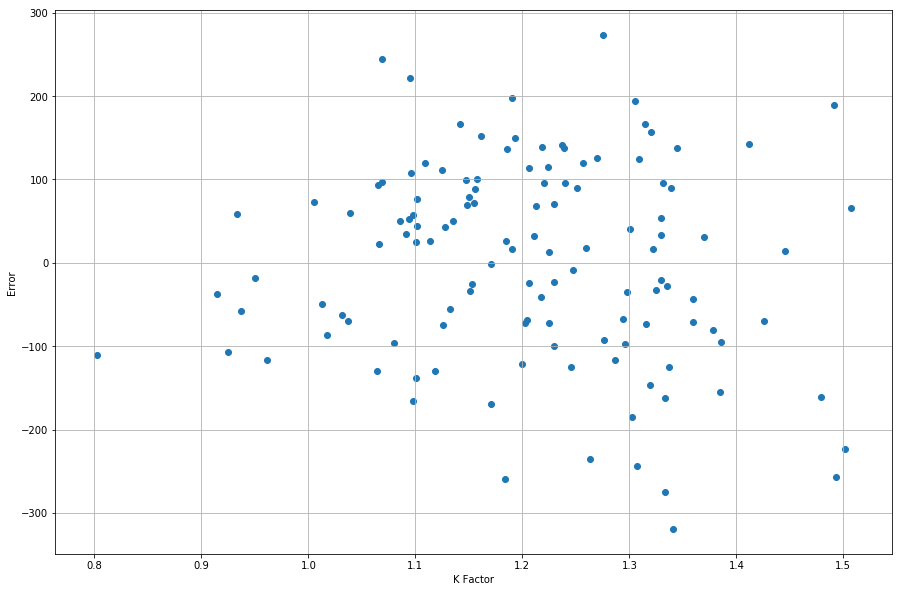

In [61]:
%matplotlib inline
plt.figure(figsize=(15, 10))
plt.grid()
plt.xlabel('K Factor')
plt.ylabel('Error')
plt.scatter(df.loc[~mask, 'kfactor'], df.loc[~mask, 'error'])
